In [1]:
import pysnnblaze as pb
import numpy as np

In [2]:
tau_m = 10.0       # membrane time constant
v_rest = -70       # resting potential
v_reset = -70      # reset potential after spike
v_thresh = -50     # threshold
refractory = 0.005   # refractory period

neuron = pb.LIFNeuron(tau_m=tau_m, v_rest=v_rest, v_reset=v_reset, v_thresh=v_thresh, refractory=refractory)

## Testing a LIF Neuron
Remark that the neuron objects contain functions that manipulates an array representing the neuron states (membrane potentials in this case). However, it does not contain the state itself. 

In [3]:
# Testing a LIF Neuron

# Network state variables
state_arr = np.array([0], dtype=np.float64)
last_spike_arr = np.array([0], dtype=np.float64)

print(f'State at start: {state_arr}')
print(f'Last spike time at start: {last_spike_arr}')

# Neurons receives a spike of weight 1 at time 0
neuron.update(0., state_arr, last_spike_arr, 0.9)
print(f'State after receiving spike: {state_arr}')
print(f'Last spike time after receiving spike: {last_spike_arr}')

# Update neuron state after 1 time unit
neuron.update(1, state_arr, last_spike_arr, 0.)
print(f'State after 1 time unit: {state_arr}')
print(f'Last spike time after 1 time unit: {last_spike_arr}')

# Update neuron state to surpass threshold
neuron.update(2, state_arr, last_spike_arr, 100)
print(f'State after surpassing threshold: {state_arr}')
print(f'Last spike time after surpassing threshold: {last_spike_arr}')

State at start: [0.]
Last spike time at start: [0.]
State after receiving spike: [-70.]
Last spike time after receiving spike: [0.]
State after 1 time unit: [-70.]
Last spike time after 1 time unit: [0.]
State after surpassing threshold: [-70.]
Last spike time after surpassing threshold: [2.]


## Testing the state monitor

In [4]:
monitor = pb.SpikeMonitor()
monitor.on_spike(0, 2)
monitor.on_spike(1, 4)
monitor.on_spike(2, 5)
monitor.spike_list

[(0.0, 2), (1.0, 4), (2.0, 5)]

## Testing a Neural Network

In [5]:
nn = pb.NeuralNetwork()
nn.set_spike_monitor(monitor)
nn.add_neuron_population(5, neuron)
monitor.reset_spikes()

# Spikes events with no synapses
nn.schedule_spike_event(0, 0, 100.)
nn.schedule_spike_event(2.2, 4, 100.)
nn.run(5.0)
print(f'Observed spike events (time, neuron id): {monitor.spike_list}')

Observed spike events (time, neuron id): [(0.0, 0), (2.2, 4)]


In [6]:
# Same experiment with 2 synapses 
nn = pb.NeuralNetwork()
nn.set_spike_monitor(monitor)
nn.add_neuron_population(5, neuron)
monitor.reset_spikes()

syn1 = pb.Synapse(0, 1, 1.0, 100.0)
syn2 = pb.Synapse(4, 2, 1.0, 100.0)

nn.add_synapse(syn1)
nn.add_synapse(syn2)

nn.schedule_spike_event(0, 0, 100.0)
nn.schedule_spike_event(2.2, 4, 100.0)

nn.run(10)
print(f'Observed spike events (time, neuron id): {monitor.spike_list}')

Observed spike events (time, neuron id): [(0.0, 0), (2.2, 4)]


## Random neural network simulation

In [34]:
import random

# Parameters
num_neurons = 50
connection_prob = 0.1
weight_range_exc = (5, 10)  # Weight range for excitatory neurons
weight_range_inh = (-30, -5)  # Weight range for inhibitory neurons
delay_range = (0.001, 0.002)
inhibitory_ratio = 0.2
num_inhibitory = int(num_neurons * inhibitory_ratio)

# Generate the Erdős–Rényi random graph with random weights and delays
graph = []
for pre in range(num_neurons):
    for post in range(num_neurons):
        if pre != post:
            if random.random() < connection_prob:
                # Determine if the presynaptic neuron is inhibitory
                if pre >= num_neurons - num_inhibitory:
                    weight = random.uniform(*weight_range_inh)
                else:
                    weight = random.uniform(*weight_range_exc)
                delay = random.uniform(*delay_range)
                graph.append((pre, post, weight, delay))

In [37]:
# Initialize network and monitor
nn = pb.NeuralNetwork()
nn.set_spike_monitor(monitor)
nn.add_neuron_population(num_neurons, neuron)
monitor.reset_spikes()

# Instantiate the graph into the neural network
for pre, post, weight, delay in graph:
    syn = pb.Synapse(pre, post, weight, delay)
    nn.add_synapse(syn)

# Parameters
spike_rate = 20.0  # spikes per second per neuron
t_start = 0.0
t_end = 5.0
input_neurons = 10

# Generate spike events for all neurons
for neuron_id in range(input_neurons):
    t = t_start
    while t < t_end:
        # Inter-spike interval sampled from exponential distribution
        isi = random.expovariate(spike_rate)  # mean interval = 1 / spike_rate
        t += isi
        if t < t_end:
            magnitude = 100.0  # spike magnitude
            nn.schedule_spike_event(t, neuron_id, magnitude)

# Run simulation
nn.run(10.)

# Output observed spikes
print(f'Number of events: {len(monitor.spike_list)}')
print(f'Observed spike events (time, neuron id): {monitor.spike_list}')

Number of events: 3104
Observed spike events (time, neuron id): [(0.0015395908947837499, 9), (0.006545365442795473, 2), (0.012379131107082988, 9), (0.01460947725154354, 0), (0.016111991358216685, 3), (0.0172605841150068, 40), (0.0203660527790923, 6), (0.03620663624150889, 7), (0.045465290605516906, 5), (0.04564768418600601, 8), (0.046398710293114785, 2), (0.04686166478981254, 4), (0.047264530183417315, 29), (0.04827845658011773, 45), (0.06332225770494099, 3), (0.06517629507807222, 24), (0.06528777878240949, 48), (0.0661074909502762, 9), (0.06779425063058288, 11), (0.06797385546646609, 40), (0.07094193709551529, 1), (0.07203498314961634, 34), (0.07248129665418547, 13), (0.07252595883962484, 21), (0.07354114051876644, 19), (0.0741146587878768, 45), (0.07420455372322184, 5), (0.07560415900600519, 17), (0.0761345567447346, 18), (0.0779016925379912, 2), (0.07795512900854225, 6), (0.07907574306499043, 42), (0.07927373643532207, 29), (0.07981036510640058, 16), (0.08091582813494524, 23), (0.08

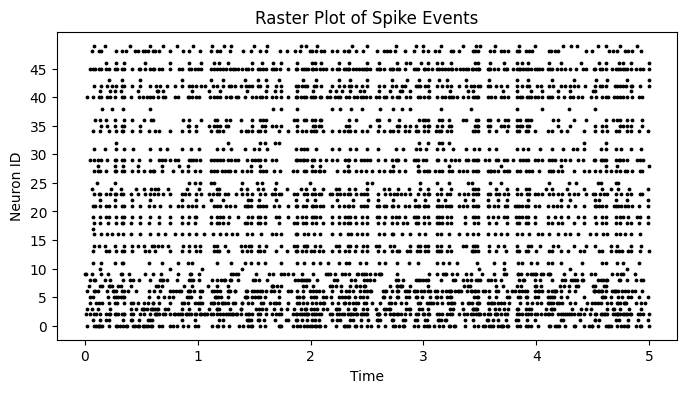

In [38]:
import matplotlib.pyplot as plt

# Plotting spike events
spike_times = [t for t, n in monitor.spike_list]
neuron_ids = [n for t, n in monitor.spike_list]

plt.figure(figsize=(8, 4))
plt.scatter(spike_times, neuron_ids, c='black', marker='o', s=3)
plt.xlabel('Time')
plt.ylabel('Neuron ID')
plt.title('Raster Plot of Spike Events')
plt.yticks(range(0, num_neurons, num_neurons//10))  # Show every 10th neuron ID
plt.show()


## Comparison to Brian 2

WARNING    'w' is an internal variable of group 'synapses_2', but also exists in the run namespace with the value -10.25349155 * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Number of spike events: 4115


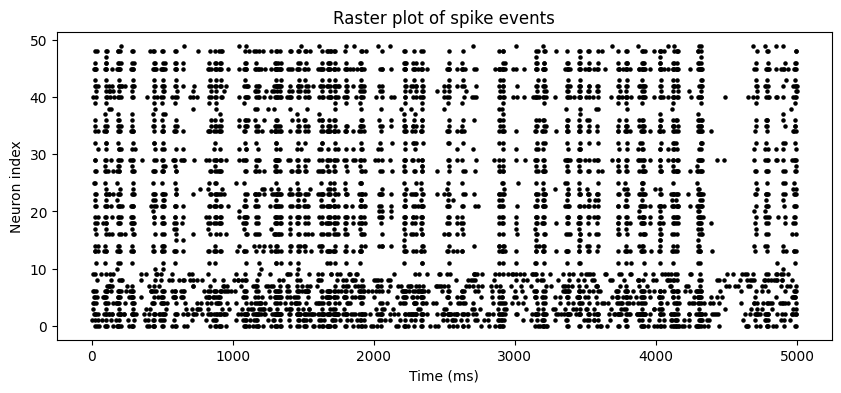

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from brian2 import *

# ==============================
# Parameters
# ==============================
num_neurons = 50
connection_prob = 0.1

weight_range_exc = (5, 10)      # Excitatory weights (mV)
weight_range_inh = (-30, -5)    # Inhibitory weights (mV)
delay_range = (1*ms, 2*ms)      # Transmission delays
inhibitory_ratio = 0.2
num_inhibitory = int(num_neurons * inhibitory_ratio)

# LIF neuron parameters
tau_m = 20*ms
v_rest = -70*mV
v_reset = -70*mV
v_thresh = -50*mV
refractory_period = 2*ms

# Poisson input parameters
spike_rate = 20*Hz
input_neurons = 10
t_end = 5*second

# ==============================
# Model definition
# ==============================
eqs = '''
dv/dt = (v_rest - v) / tau_m : volt (unless refractory)
'''

G = NeuronGroup(num_neurons, eqs, threshold='v>v_thresh',
                reset='v=v_reset', refractory=refractory_period,
                method='exact')
G.v = v_rest

# ==============================
# Synapses with Erdős–Rényi connectivity
# ==============================
S = Synapses(G, G, 'w : volt', on_pre='v_post += w')

# Build connectivity
for pre in range(num_neurons):
    for post in range(num_neurons):
        if pre != post and np.random.random() < connection_prob:
            if pre >= num_neurons - num_inhibitory:  # inhibitory
                w = np.random.uniform(*weight_range_inh) * mV
            else:  # excitatory
                w = np.random.uniform(*weight_range_exc) * mV
            d = np.random.uniform(delay_range[0]/second, delay_range[1]/second) * second
            S.connect(i=pre, j=post)
            S.w[pre, post] = w
            S.delay[pre, post] = d

# ==============================
# External Poisson input
# ==============================
P = PoissonGroup(input_neurons, rates=spike_rate)

# Connect external inputs to first input_neurons in G
SP = Synapses(P, G, on_pre='v_post += 100*mV')  # input strength
SP.connect(i=np.arange(input_neurons), j=np.arange(input_neurons))

# ==============================
# Monitors
# ==============================
spikemon = SpikeMonitor(G)
statemon = StateMonitor(G, 'v', record=0)  # record neuron 0 as example

# ==============================
# Run simulation
# ==============================
run(t_end)

# ==============================
# Results
# ==============================
print(f"Number of spike events: {spikemon.num_spikes}")

# Raster plot
plt.figure(figsize=(10,4))
plt.scatter(spikemon.t/ms, spikemon.i, s=5, c='black')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron index')
plt.title('Raster plot of spike events')
plt.show()